Ce code prend en paramètre le catalogue NAEC filtré et calcule la distribution de fréquence des vorticités moyennées autour de 800km et sur la durée de vie de chaque tempête dans le domaine de CRCM6. Pour plus de détails, voir fichier "methods" (voir Maxine Cloutier - Gervais).

In [2]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np                       
from datetime import datetime
from scipy.stats import spearmanr, pearsonr

from matplotlib.patches import Patch
import matplotlib as mpl
import matplotlib.pyplot as plt            
import matplotlib.colors as colors
from matplotlib import gridspec,rc

In [3]:
# Get filtered catalogue
df = pd.read_csv('/pampa/cloutier/storm_tracks/filtered/etc24_consec_season.csv', index_col=0)

In [12]:
seasons = ['JJA', 'SON', 'DJF', 'MAM']
var = 'VORS_av08'
n_var = 'norm_' + var

# Only keep cyclone centers within CRCM6 subdomain
df_true = df.loc[df.HU == True].copy()
df_true = df_true.groupby(['storm', 'season'])[var].mean().reset_index()

# get mean value and sigma over the crcm6 lifetime (where crcm6 mask is True)
mean_vors = df_true[var].mean()
std_vors = df_true[var].std()

# normalize the vorticity
df_true[n_var] = (df_true[var] - mean_vors) / std_vors

# separate seasons 
df_seasons = {}
for s in seasons : 
    arr_name = f"df_{s}"
    df_seasons[arr_name] = df_true.loc[df_true.season == s]

# create numpy arrays with the normalized vorticities of each season 
nvor_seasons = {}
for s in seasons : 
    vor_name = f'vors_{s}'
    df_name = f"df_{s}"
    nvor_seasons[vor_name] = df_seasons[df_name][n_var].to_numpy() 

In [29]:
# Count the number of values for each season between each bin

# normalized bins
bins = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]
bin_count = {}

# 
for s in seasons : 
    
    arr_name = f'bin_count_{s}'
    vor_name = vor_name = f'vors_{s}'
    vor_len = len(nvor_seasons[vor_name])
    
    # initialize bin_count at 0 for each season
    bin_count[s] = np.zeros(len(bins) + 1)
    
    # count number of values between each bins 
    for value in nvor_seasons[vor_name] : 
        for i in range(len(bins) + 1) : 
            if i == 0 and value < bins[i] : 
                bin_count[s][0] += 1
                break
            elif bins[i-1] <= value < bins[i] : 
                bin_count[s][i]+= 1
                break

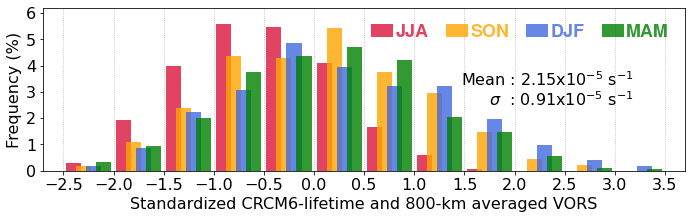

In [46]:
seasons = ['JJA', 'SON', 'DJF', 'MAM']
colors = ['crimson', 'orange', 'royalblue', 'g']
a = 0.8
gaps = [-0.1,-0.2,-0.3,-0.4] # gap between bars
fs = 16

meanvors = mean_vors
sigmvors = std_vors
length = len(df_true)

fig = plt.figure(figsize=(11.5,3))
gs = gridspec.GridSpec(1,1)
ax=plt.subplot(gs[0])

xc=np.arange(-2.5, 4., 0.5)
width=0.15

for s, g, c in zip(seasons, gaps, colors) :
    cs2 = plt.bar(xc[:]-g, bin_count[s][:]*100./length, width,color=c, alpha=a, label = s)
    
# cs2 = plt.bar(xc[:]-0.4,Bnwdsp_jja[:]*100./length,width,color='crimson',alpha=0.8, label = 'JJA')
# cs2 = plt.bar(xc[:]-0.3,Bnwdsp_son[:]*100./length,width,color='orange',alpha=0.8, label='SON')
# cs2 = plt.bar(xc[:]-0.2,Bnwdsp_djf[:]*100./length,width,color='royalblue',alpha=0.8, label='DJF')
# cs2 = plt.bar(xc[:]-0.1,Bnwdsp_mam[:]*100./length,width,color='green',alpha=0.7, label='MAM')


legend = plt.legend(frameon=False, ncol=len(seasons), columnspacing=0.5, handlelength=1,
                    prop = {'family' : 'Nimbus Sans', 'size' : 18, 'weight' : 'bold'})

for i, color in zip(range(0,len(seasons)), colors):
    #legend.get_texts()[i].set_position((-2, 0.5))
    text = legend.get_texts()[i]  # Get the first legend text
    text.set_color(color) # text color
    text.set_alpha(0.8) # text transparency
    handle = legend.legendHandles[i]
    handle.set_width(22) # rectangle width
    handle.set_x(8) # Move the rectangle closer horizontally
    
plt.xlim(-2.7,3.7)
plt.ylim(0,6.2)
ax.set_xticks([-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5])
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
ax.set_ylabel('Frequency (%)',fontsize=fs)
ax.set_xlabel('Standardized CRCM6-lifetime and 800-km averaged VORS',fontsize=fs)
plt.grid(True,axis='x',linestyle=':')

ax.text(0.92,0.52,'Mean : '+'{:,.2f}'.format(meanvors*1.e5)+'x$10^{-5}\ \mathrm{s}^{-1}$',
        color='k',transform=ax.transAxes,ha='right',fontsize=fs)
ax.text(0.92,0.40,'$\sigma$  : '+'{:,.2f}'.format(sigmvors*1.e5)+'x$10^{-5}\ \mathrm{s}^{-1}$',
        color='k',transform=ax.transAxes,ha='right',fontsize=fs)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig('/pampa/cloutier/fig/freq_dist_std_vors800.png', dpi=300, bbox_inches='tight')
plt.show()